# Class 7 & 8: Model Evaluation

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics

import seaborn as sns
sns.set_style("darkgrid")

%matplotlib inline

import statsmodels.formula.api as smf

#### How do we minimize error?

The regression we've been using in class is called "ordinary least squares," which literally means given a matrix X, solve for the _least_ amount of squared error for y. However, this approach assumes that the sample X is representative of the population; that is, it assumes that the sample is _unbiased_. For example, let's compare these two random models:

```python
import numpy as np
import pandas as pd
from sklearn import linear_model

df = pd.DataFrame({'x': range(100), 'y': range(100)})
biased_df  = df.copy()
biased_df.loc[:20, 'x'] = 1
biased_df.loc[:20, 'y'] = 1

def append_jitter(series):
    jitter = np.random.random_sample(size=100)
    return series + jitter

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)
```


### Create sample data and fit a model

In [110]:
df = pd.DataFrame({'x': range(100), 'y': range(100)})
biased_df  = df.copy()
biased_df.loc[:50, 'x'] = 100
biased_df.loc[:50, 'y'] = 100

def append_jitter(series):
    jitter = np.random.random_sample(size=100)
    return series + jitter

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)

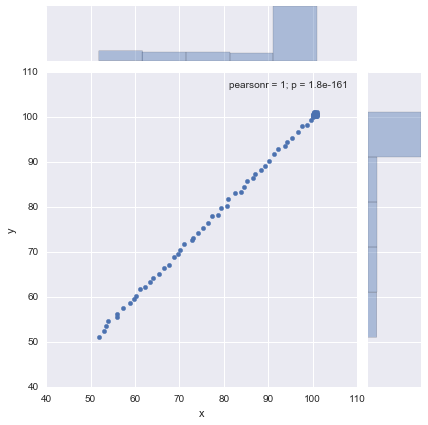

In [111]:
sns.jointplot(data=biased_df, x='x', y='y')

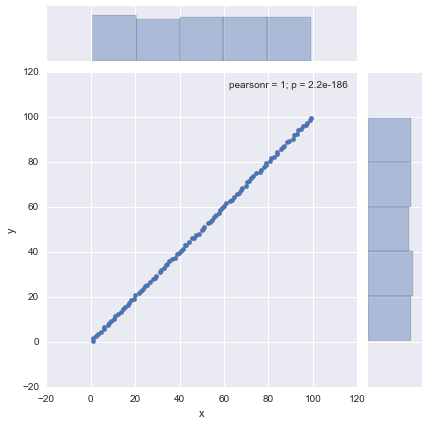

In [112]:
sns.jointplot(data=df, x='x', y='y')

In [ ]:
## fit
lm = linear_model.LinearRegression().fit(df[['x']], df['y'])


print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))

In [ ]:
## biased fit
lm = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])

print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))

- Fit:
```
lm = linear_model.LinearRegression().fit(df[['x']], df['y'])
print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))
```

- Biased fit:
```
lm = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])
print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))
```


![Explanation of bias error](http://i.stack.imgur.com/JLDET.png)

When our error is described as _biased_, it means that the learner's prediction is consistently far away from the actual answer. This is a sign of poor sampling: perhaps the population is not well represented in the model, or other data needs to be collected.

Otherwise, one objective of a _biased_ model is to trade this biased error for _generalized_ error. That is, we'd prefer if the error was distributed more evenly across the model, even if that means it doesn't explain the sample as well. This is called error due to _variance_.

Since the whole point of prediction is for a model to work on data that the model hasn't seen yet, your want your model to perform _generally_ well on new data! If your model has a lot of _bias_, then even if you have a good r-squared or mean squared error from learned data, it could still perform **poorly** on new predictive data.

**Check:** Which of the following scenarios would be better for a weatherman?:

1. Knowing that I can very accurately "predict" the temperature outside from previous days perfectly, but be 20-30 degrees off for future days?
2. Knowing that I can accurately predict the general trend of the temperate outside from previous days, and therefore am at most only 10 degrees off on future days?

## Cross validation

**Motivating question: How do we sample the data we'll use to fit our model? (Training data)**

One approach data scientists use to account for bias is cross validation. The basic idea of cross validation is to generate several models based on different cross sections of the data, measure performance of each, and then take the mean performance. This technique is one way to swap bias error for generalized error in our model.

In other words, this method helps us create weatherman Scenario 2 - describing previous trends with a general amount of accuracy in order to make more specifically accurate predictions about future trends.

![crossvalidation_kfold](http://i.stack.imgur.com/8hyyh.png)

One of the most common cross validation techniques is called **k-fold**: split the data into _k_ groups, _train_ the data on all segments except one, and then _test_ the performance on the remaining set. If k equals five, then you split the data into five groups and generate five different models.

What happens to mean squared error if we use k-fold validation to _generalize_ the error?

```python
from sklearn import cross_validation
wd = '../../datasets/'
bikeshare = pd.read_csv(wd + 'bikeshare/bikeshare.csv')
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual

kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)
scores = []
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))

print np.mean(scores)

- This score will be lower, but we're trading off bias error for generalized error:
lm = linear_model.LinearRegression().fit(modeldata, y)
print metrics.mean_squared_error(y, lm.predict(modeldata))
```

**Check:** While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?

***


#### Intro to cross validation with bike share data from last time. We will be modeling casual ridership. 

In [ ]:
from sklearn import cross_validation

bikeshare = pd.read_csv('https://github.com/ga-students/DAT-NYC-37/raw/master/lessons/lesson-07/assets/dataset/bikeshare.csv')

#### Create dummy variables and set outcome (dependent) variable

In [ ]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual 

#### Create a cross valiation with 5 folds

In [ ]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [ ]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

In [ ]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'R2: ', lm.score(modeldata, y)

### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

### There are ways to improve our model with regularization. 
Let's check out the effects on MSE and R2

In [ ]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'OLS R2:', lm.score(modeldata, y)

lm = linear_model.Lasso().fit(modeldata, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'Lasso R2:', lm.score(modeldata, y)

# http://statweb.stanford.edu/~tibs/lasso/simple.html

lm = linear_model.Ridge().fit(modeldata, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'Ridge R2:', lm.score(modeldata, y)

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### Figuring out the alphas can be done by "hand"

In [ ]:
alphas = np.logspace(-10, 10, 21)
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(modeldata, y)
    print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(modeldata))

### Or we can use grid search to make this faster

In [ ]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(modeldata, y)


##### Best score 

In [ ]:
print gs.best_score_ 

##### mean squared error here comes in negative, so let's make it positive.

In [ ]:
print -gs.best_score_ 

##### explains which grid_search setup worked best

In [ ]:
print gs.best_estimator_ 

##### shows all the grid pairings and their performances.

In [ ]:
print gs.grid_scores_ 

## Gradient Descent

In [ ]:
num_to_approach, start, steps, optimized = 6.2, 0., [-1, 1], False
while not optimized:
    current_distance = num_to_approach - start
    got_better = False
    next_steps = [start + i for i in steps]
    for n in next_steps:
        distance = np.abs(num_to_approach - n)
        if distance < current_distance:
            got_better = True
            print distance, 'is better than', current_distance
            current_distance = distance
            start = n
    if got_better:
        print 'found better solution! using', current_distance
        a += 1
    else:
        optimized = True
        print start, 'is closest to', num_to_approach


###Bonus: 
implement a stopping point, similar to what n_iter would do in gradient descent when we've reached "good enough"

## Demo: Application of Gradient Descent 

In [ ]:
lm = linear_model.SGDRegressor()
lm.fit(modeldata, y)
print "Gradient Descent R2:", lm.score(modeldata, y)
print "Gradient Descent MSE:", metrics.mean_squared_error(y, lm.predict(modeldata))

### Check: Untuned, how well did gradient descent perform compared to OLS?

Answer: 

# Independent Practice: Bike data revisited

There are tons of ways to approach a regression problem. The regularization techniques appended to ordinary least squares optimizes the size of coefficients to best account for error. Gradient Descent also introduces learning rate (how aggressively do we solve the problem), epsilon (at what point do we say the error margin is acceptable), and iterations (when should we stop no matter what?)

For this deliverable, our goals are to:

- implement the gradient descent approach to our bike-share modeling problem,
- show how gradient descent solves and optimizes the solution,
- demonstrate the grid_search module!

While exploring the Gradient Descent regressor object, you'll build a grid search using the stochastic gradient descent estimator for the bike-share data set. Continue with either the model you evaluated last class or the simpler one from today. In particular, be sure to implement the "param_grid" in the grid search to get answers for the following questions:

- With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
- Based on the data, we know when to properly use l1 vs l2 regularization. By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does that statement hold true? If not, did gradient descent have enough iterations?
- How do these results change when you alter the learning rate (eta0)?

**Bonus**: Can you see the advantages and disadvantages of using gradient descent after finishing this exercise?

### Starter Code

In [ ]:
params = {} # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print 'BEST ESTIMATOR'
print -gs.best_score_
print gs.best_estimator_
print 'ALL ESTIMATORS'
print gs.grid_scores_

In [ ]:
## go for it!